# World Data League 2022

## 🎯 Challenge
Predict Waste Production for its Reduction


## 👥 Authors
* Cristiana Carpinteiro
* Diogo Valente Polónia
* João Afonso
* João Matos
* Patrícia Rocha

## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters.

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

In [2]:
# Uncomment to install some of the libraries below
# !pip3 install geopandas

#import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xgboost

from google.colab import drive
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'xgboost'

In [2]:
rcParams['figure.figsize'] = 16, 8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.

In [3]:
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(working_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

In [3]:
data = pd.read_csv('Waste_Collection___Diversion_Report__daily_.csv')
data['Load Time'] = pd.to_datetime(data['Load Time'], format='%m/%d/%Y %I:%M:%S %p')

In [5]:
data

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
0,12/08/2020,BULK,2020-12-08 15:02:00,5220.0,TDS LANDFILL,BULK,BU13,899097
1,12/08/2020,RECYCLING - SINGLE STREAM,2020-12-08 10:00:00,11140.0,TDS - MRF,RECYCLING - SINGLE STREAM,RTAU53,899078
2,12/03/2020,RECYCLING - SINGLE STREAM,2020-12-03 10:34:00,10060.0,BALCONES RECYCLING,RECYCLING - SINGLE STREAM,RHBU10,899082
3,12/07/2020,SWEEPING,2020-12-07 10:15:00,7100.0,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,899030
4,12/07/2020,RECYCLING - SINGLE STREAM,2020-12-07 16:00:00,12000.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMAU53,899048
...,...,...,...,...,...,...,...,...
740868,04/09/2008,RECYCLING - PAPER,2021-07-11 07:00:39,1080.0,MRF,RECYCLING,RW05,273708
740869,12/01/2015,BULK,2021-07-11 07:05:29,9360.0,TDS LANDFILL,STORM,HAFLDBU15,676651
740870,04/25/2007,YARD TRIMMING,2021-07-11 07:01:56,NaN,HORNSBY BEND,YARD TRIMMINGS,YW04,224646
740871,04/09/2008,RECYCLING - COMINGLE,2021-07-11 07:00:39,3960.0,MRF,RECYCLING,RW04,273706


### Dataset Description

Austin Resource Recovery daily report providing waste collection information. The dataset was last updated on July 11, 2021, and consists of roughly 741,000 rows and eight columns.

Columns description:
* Report Date - the date when the information was recorded
* Load Type - the specific type of load that is being collected
* Load Time - the time when the load was collected
* Load Weight - the weight, in pounds, of the load
* Dropoff Site - the location where each type of waste is delivered for disposal, recycling, or reuse
* Route Type - the general category of collection service provided by Austin Resource Recovery
* Route Number - Austin Resource Recovery route that the truck that collected this load was following
* Load ID

In [6]:
# Use Load Time as key timestamp
data.drop('Report Date', axis=1, inplace=True)

data.dropna(subset=['Load Weight'], inplace=True)
data = data[data['Load Weight'] > 0]

# Remove data post July 11, 2021 (the last time this dataset was updated)
data = data[data['Load Time'] < '2021-07-12']

# Remove entries that are likely to be duplicates
data['Load Date'] = pd.to_datetime(data['Load Time'].dt.date)
data = data.drop_duplicates(subset=['Load Type', 'Load Weight', 'Dropoff Site', 'Route Type', 'Route Number', 'Load Date'])

data.drop_duplicates(subset=['Load Type', 'Load Weight', 'Load ID'], keep='last', inplace=True, ignore_index=True)

In [7]:
assert len(data) == len(data['Load ID'].unique()), 'Number of IDs does not match with number of samples'

In [8]:
data.sort_values('Load Time', inplace=True, ignore_index=True)
data

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date
0,RECYCLING - PAPER,2000-01-26 12:39:00,2940.0,MRF,RECYCLING,RH12,163262,2000-01-26
1,BULK,2001-03-16 09:38:00,4240.0,TDS LANDFILL,BULK,BU05,522335,2001-03-16
2,BULK,2001-03-16 13:33:00,4740.0,TDS LANDFILL,BULK,BU05,522334,2001-03-16
3,BULK,2001-10-16 11:51:00,14080.0,TDS LANDFILL,BULK,BU16,545997,2001-10-16
4,BULK,2001-10-16 15:28:00,8260.0,TDS LANDFILL,BULK,BU16,545996,2001-10-16
...,...,...,...,...,...,...,...,...
655357,BULK,2021-07-11 07:07:01,10100.0,TDS LANDFILL,BULK,BU27,842414,2021-07-11
655358,TIRES,2021-07-11 07:07:05,1500.0,TDS LANDFILL,BULK,BU16,848381,2021-07-11
655359,TIRES,2021-07-11 07:07:05,2120.0,MRF,BULK,BU16,848380,2021-07-11
655360,GARBAGE COLLECTIONS,2021-07-11 07:07:42,17200.0,TDS LANDFILL,GARBAGE COLLECTION,PW30,928229,2021-07-11


In [9]:
data['Load Type'].value_counts()

GARBAGE COLLECTIONS            258168
RECYCLING - SINGLE STREAM      147372
YARD TRIMMING                   67150
BULK                            39698
RECYCLING - PAPER               32055
RECYCLING - COMINGLE            30978
BRUSH                           30278
ORGANICS                        17667
SWEEPING                        16461
DEAD ANIMAL                      6839
TIRES                            3188
MIXED LITTER                     2082
LITTER                           1539
RECYCLED METAL                   1041
MULCH                             728
BAGGED LITTER                      43
RECYCLING - PLASTIC BAGS           40
YARD TRIMMING - X-MAS TREES        16
MATTRESS                            9
CONTAMINATED RECYCLING              8
CONTAMINATED YARD TRIMMINGS         1
CONTAMINATED ORGANICS               1
Name: Load Type, dtype: int64

In [9]:
data.to_csv('waste_collection.csv')

### EDA

In [ ]:
load_types = data['Load Type'].unique()

for load in load_types: 
  data_perload = data[data['Load Type']==load]
  data_perload_2020 = data_perload[data_perload['Load Time'].dt.year==2020]
  data_perload_2020_january = data_perload_2020[data_perload_2020['Load Time'].dt.month==1]
  fig1, ax1 = plt.subplots()
  ax1.set_title(load)
  sns.scatterplot(x = 'Load Time', y = 'Load Weight', data = data_perload_2020_january, ax = ax1, hue='Route Type')

In [ ]:
load_types = data['Load Type'].unique()

for load in load_types: 
  data_perload = data[data['Load Type']==load]
  data_perload_2020 = data_perload[data_perload['Load Time'].dt.year==2020]
  data_perload_2020_january = data_perload_2020[data_perload_2020['Load Time'].dt.month==1]
  fig1, ax1 = plt.subplots()
  ax1.set_title(load)
  sns.scatterplot(x = 'Load Time', y = 'Load Weight', data = data_perload_2020_january, ax = ax1, hue='Route Number')

In [ ]:
load_types = data['Load Type'].unique()
data['month'] = data['Load Time'].dt.month
fig1, ax1 = plt.subplots()
ax1.set_title('Garbage collected by month') 
for load in load_types: 
  data_per_load = data[data['Load Type']==load]
  data_perload_2020 = data_per_load[data_per_load['Load Time'].dt.year==2020]
  data_permonth = data_perload_2020.groupby(by=['month']).sum()
  sns.lineplot(x = 'month', y = 'Load Weight', data = data_permonth, ax = ax1, label=load)
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
data['month'] = data['Load Time'].dt.month
fig1, ax1 = plt.subplots()
ax1.set_title('Garbage collected by month') 
data_2020 = data[data['Load Time'].dt.year==2020]
data_permonth = data_2020.groupby(by=['month', 'Route Type']).mean()
sns.scatterplot(x = 'month', y = 'Load Weight', data = data_permonth, ax = ax1, hue='Route Type')
plt.legend(bbox_to_anchor=(1, 1))

**Garbage Collection Routes**

The data provided spans years in which Austin grew and changed a lot, very likely with changing waste collection and routes too, which most likely accounts for some of the routes in the dataset not being in the current route map(s). There are also some route numbers that occur only once, most likely signifying on-demand waste collection, which would not appear in the regular boundaries map.

In conclusion, some route numbers do not have a bounded region, therefore we will only focus on the ones that do.

In [15]:
garbage_boundaries = gpd.read_file('garbage_routes.geojson')

In [16]:
garbage_boundaries.head()

,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ..."
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ..."
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ..."
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ..."
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ..."


In [17]:
route_numbers = list(garbage_boundaries['garb_rt'])
aux = data[data['Route Number'].isin(route_numbers)]

In [18]:
aux['Load Type'].value_counts()

GARBAGE COLLECTIONS          171151
RECYCLING - SINGLE STREAM        18
TIRES                             9
YARD TRIMMING                     2
SWEEPING                          2
MIXED LITTER                      1
BAGGED LITTER                     1
CONTAMINATED ORGANICS             1
Name: Load Type, dtype: int64

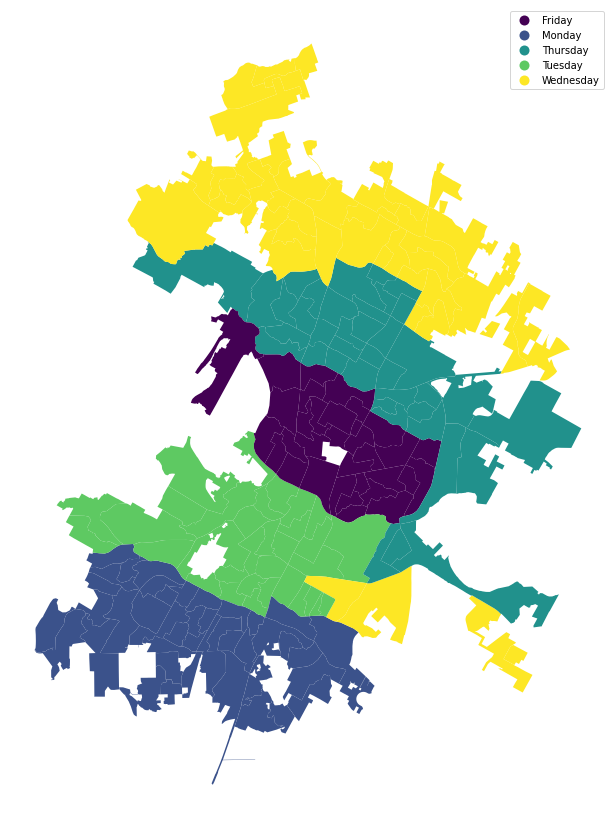

In [19]:
ax = garbage_boundaries.plot(column='garb_day', cmap='viridis', legend=True, figsize=(15, 15), legend_kwds={'bbox_to_anchor': (1, 1)})
ax.set_axis_off()

In [20]:
aux_2020 = aux[(aux['Load Type'] == 'GARBAGE COLLECTIONS') & (aux['Load Time'].dt.year == 2020)]

In [21]:
for garb_rt in route_numbers:
  garbage_boundaries.loc[garbage_boundaries['garb_rt'] == garb_rt, 'load'] = aux_2020[aux_2020['Route Number'] == garb_rt]['Load Weight'].sum()

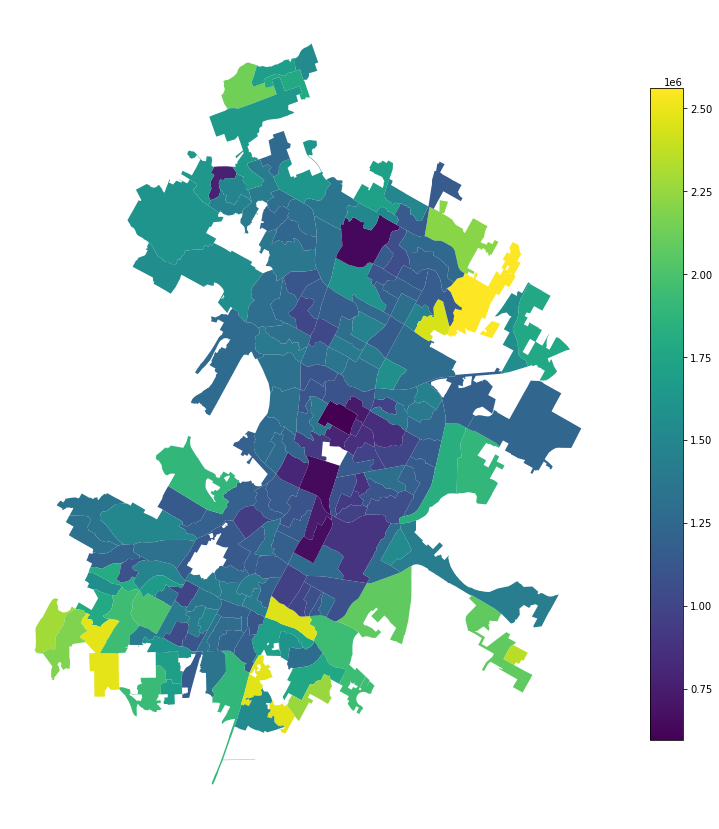

In [22]:
# Collected Garbage / route in Austin
ax = garbage_boundaries.plot(column='load', legend=True, figsize=(15, 15), legend_kwds={'shrink': 0.8})
ax.set_axis_off()

Try matching the routes with the zip codes:

In [23]:
zip_codes = gpd.read_file('austin_area_zip_codes.geojson')
zip_codes

,geodb_oid,objectid,zipcodes_i,zipcode,name,created_by,created_da,modified_b,modified_d,shape_area,shape_len,cartodb_id,created_at,updated_at,geometry
0,3,3,56,78739,AUSTIN,None,None,None,None,3.383405e+08,97785.793334,3,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ..."
1,4,4,57,78645,LEANDER,None,None,None,None,1.043396e+09,196654.442800,4,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.91075 30.50110, -97.91053 ..."
2,16,16,10,78602,BASTROP,None,None,None,None,5.914482e+09,506803.883037,9,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.27371 30.29662, -97.27323 ..."
3,17,17,11,78655,MARTINDALE,None,None,None,None,1.846886e+09,212904.793003,10,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.73690 29.78761, -97.73582 ..."
4,18,18,12,78617,DEL VALLE,None,None,None,None,1.885224e+09,273994.824301,11,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.51624 30.21906, -97.51600 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,80,80,70,78660,PFLUGERVILLE,None,None,None,None,1.213141e+09,190996.848040,71,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.57653 30.50086, -97.57450 ..."
76,63,63,74,78662,RED ROCK,None,None,None,None,1.357638e+09,174824.670167,74,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.45105 30.01521, -97.44517 ..."
77,64,64,75,78705,AUSTIN,None,None,None,None,5.548433e+07,51538.164415,75,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.72978 30.29871, -97.72893 ..."
78,68,68,79,78701,AUSTIN,None,None,None,None,4.756859e+07,34474.871995,79,2015-06-07T00:48:14+00:00,2015-06-07T00:48:14+00:00,"MULTIPOLYGON (((-97.73599 30.25101, -97.73589 ..."


In [24]:
for i, route in enumerate(garbage_boundaries['garb_rt']):
  mask = (garbage_boundaries['garb_rt'] == route)
  codes = []
  for j, code in enumerate(zip_codes['zipcode']):
    if garbage_boundaries.loc[i, 'geometry'].intersects(zip_codes.loc[j, 'geometry']):
      codes.append(zip_codes.loc[j, 'zipcode'])

  garbage_boundaries.loc[mask, 'zipcode'] = ' '.join(codes)
  

In [25]:
garbage_boundaries.head()

,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry,load,zipcode
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ...",1601320.0,78757 78758 78759
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ...",1694420.0,78748
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ...",1941260.0,78744
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ...",1887360.0,78725 78724
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ...",2210680.0,78653 78754 78753 78660


We scraped the information on population by zipcode from ZipAtlas. We checked whether the website allows web scraping by appending “/robots.txt” to the end of the URL of the website (http://zipatlas.com/robots.txt).

In [26]:
population_by_zipcode = pd.read_excel('population_by_zipcode.xlsx')
population_by_zipcode.head()

,Zip Code,Population,People / Sq. Mile
0,78705,26825,11008.66
1,78751,14005,5822.28
2,78752,1803,5435.92
3,78741,40661,5346.47
4,78723,3011,5175.95


In [27]:
# Check if all zip codes are listed on the zip code dataset
for zip_codes in garbage_boundaries['zipcode']:
  mask = (garbage_boundaries['zipcode'] == zip_codes)
  zip_codes = zip_codes.split()
  listed_codes = []
  for code in zip_codes:
    if int(code) in list(population_by_zipcode['Zip Code']):
      listed_codes.append(code)

  garbage_boundaries.loc[mask, 'listed zipcode'] = ' '.join(listed_codes)

In [28]:
for zip_codes in garbage_boundaries['listed zipcode']:
  mask = (garbage_boundaries['listed zipcode'] == zip_codes)
  zip_codes = zip_codes.split()

  pop_density = []
  for code in zip_codes:
    if int(code) in list(population_by_zipcode['Zip Code']):
      pop_density.append(population_by_zipcode[population_by_zipcode['Zip Code'] == int(code)]['People / Sq. Mile'].values[0])

  garbage_boundaries.loc[mask, 'People/Sq. Mile'] = np.mean(pop_density)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
mask = garbage_boundaries['People/Sq. Mile'].isna()
garbage_boundaries.loc[mask, 'People/Sq. Mile'] = np.nanmean(list(garbage_boundaries['People/Sq. Mile']))

In [30]:
garbage_boundaries.drop('zipcode', axis=1, inplace=True)
garbage_boundaries.rename(columns={'listed zipcode': 'zipcode'}, inplace=True)

In [31]:
pd.set_option('display.max_rows', None)
garbage_boundaries

,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry,load,zipcode,People/Sq. Mile
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ...",1601320.0,78757 78758 78759,4111.466667
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ...",1694420.0,78748,1961.730000
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ...",1941260.0,78744,1464.780000
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ...",1887360.0,78725 78724,336.360000
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ...",2210680.0,78754 78753,2229.345000
5,PH23,Thursday,TDS,PH21,None,Semi,Clark,"MULTIPOLYGON (((-97.58269 30.30467, -97.57229 ...",1234860.0,78724,555.850000
6,PAM64,Monday,TDS,PAM80,697,Auto,Gilbert,"MULTIPOLYGON (((-97.83873 30.20778, -97.83851 ...",1337860.0,78749 78745,3429.120000
7,PAT84,Tuesday,TDS,PAT71,596,Auto,Carnline,"MULTIPOLYGON (((-97.79101 30.20522, -97.79100 ...",1406960.0,78745,4063.220000
8,None,Monday,TDS,PAM01,None,Auto,Herrera,"MULTIPOLYGON (((-97.90272 30.19774, -97.90267 ...",2290340.0,78739 78737,456.350000
9,None,Monday,TDS,PAM02,None,Auto,Herrera,"MULTIPOLYGON (((-97.88210 30.20619, -97.87940 ...",1780380.0,78739 78749,1781.910000


In [32]:
density_by_route = {key: value for (key, value) in zip(list(garbage_boundaries['garb_rt']), list(garbage_boundaries['People/Sq. Mile']))}

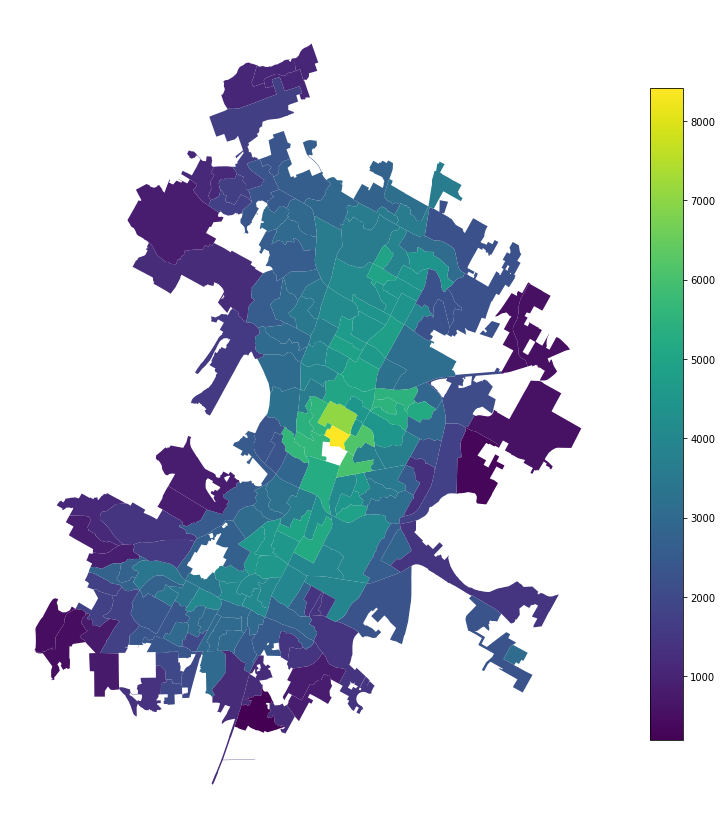

In [33]:
# Population Density / route in Austin
ax = garbage_boundaries.plot(column='People/Sq. Mile', legend=True, figsize=(15, 15), legend_kwds={'shrink': 0.8})
ax.set_axis_off()

**Garbage Collection Routes**


In [34]:
recycling_boundaries = gpd.read_file('recycling_routes.geojson')
recycling_boundaries.head()

,created_by,shape_area,area_supervisor,created_date,objectid_1,old_route,objectid,route_name,service_week,shape_length,modified_by,cart_delivery,service_day,modified_date,primary_key,geometry
0,Zimmerman,37060562.8085938,Willie Simmons,2007-10-01T00:00:00+00:00,147,RHBU16,182,RHBU13,B,32863.7931563218,Zimmerman,Oct 10 - Oct 29,Thursday,2020-09-28T00:00:00+00:00,149,"MULTIPOLYGON (((-97.77291 30.36593, -97.77288 ..."
1,Zimmerman,19838551.0253906,Johnny Williams,2007-10-01T00:00:00+00:00,77,RHBU13,93,RHBU53,B,21073.4691183319,Zimmerman,Oct 10 - Oct 29,Thursday,2020-09-28T00:00:00+00:00,78,"MULTIPOLYGON (((-97.76215 30.35763, -97.76207 ..."
2,Zimmerman,10138292.75,Willie Simmons,2007-10-01T00:00:00+00:00,42,RTAU12,49,RTAU12,A,14802.0931359868,Zimmerman,Nov 17 - Dec 2,Tuesday,2020-09-28T00:00:00+00:00,43,"MULTIPOLYGON (((-97.78116 30.22779, -97.78141 ..."
3,Zimmerman,26332018.9570313,Willie Simmons,2007-10-01T00:00:00+00:00,125,RFAU16,148,RFAU11,A,27218.9661254287,Zimmerman,Oct 29 - Nov 15,Friday,2020-10-13T00:00:00+00:00,126,"MULTIPOLYGON (((-97.75838 30.30331, -97.75835 ..."
4,Zimmerman,25537794.7128906,Chris Farr,2007-10-01T00:00:00+00:00,16,RMAS40,18,RMAS40,A,24756.3262855686,Zavala,Dec 2 - Dec 20,Monday,2020-10-01T00:00:00+00:00,16,"MULTIPOLYGON (((-97.79855 30.19531, -97.79823 ..."


In [35]:
route_numbers = list(recycling_boundaries['route_name'])
data_recycling = data[data['Route Number'].isin(route_numbers)]

In [36]:
data_recycling["Load Type"].value_counts()

RECYCLING - SINGLE STREAM    89291
RECYCLING - COMINGLE           232
RECYCLING - PAPER              222
SWEEPING                        24
RECYCLED METAL                  16
GARBAGE COLLECTIONS              3
CONTAMINATED RECYCLING           3
Name: Load Type, dtype: int64

In [37]:
recycling_boundaries.columns

Index(['created_by', 'shape_area', 'area_supervisor', 'created_date',
       'objectid_1', 'old_route', 'objectid', 'route_name', 'service_week',
       'shape_length', 'modified_by', 'cart_delivery', 'service_day',
       'modified_date', 'primary_key', 'geometry'],
      dtype='object')

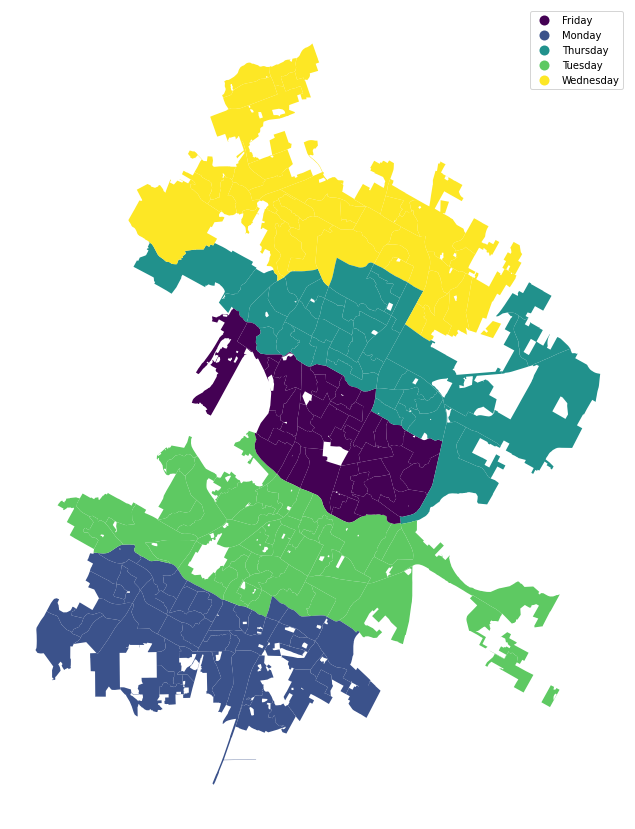

In [38]:
ax = recycling_boundaries.plot(column='service_day', cmap='viridis', legend=True, figsize=(15, 15), legend_kwds={'bbox_to_anchor': (1, 1)})
ax.set_axis_off()

In [39]:
data_recycling = data_recycling[data_recycling['Load Type'] == 'RECYCLING - SINGLE STREAM']
data_recycling_2020 = data_recycling[data_recycling['Load Time'].dt.year == 2020]

In [40]:
for garb_rt in recycling_boundaries['route_name']:
  recycling_boundaries.loc[recycling_boundaries['route_name'] == garb_rt, 'load'] = data_recycling_2020[data_recycling_2020['Route Number'] == garb_rt]['Load Weight'].sum()

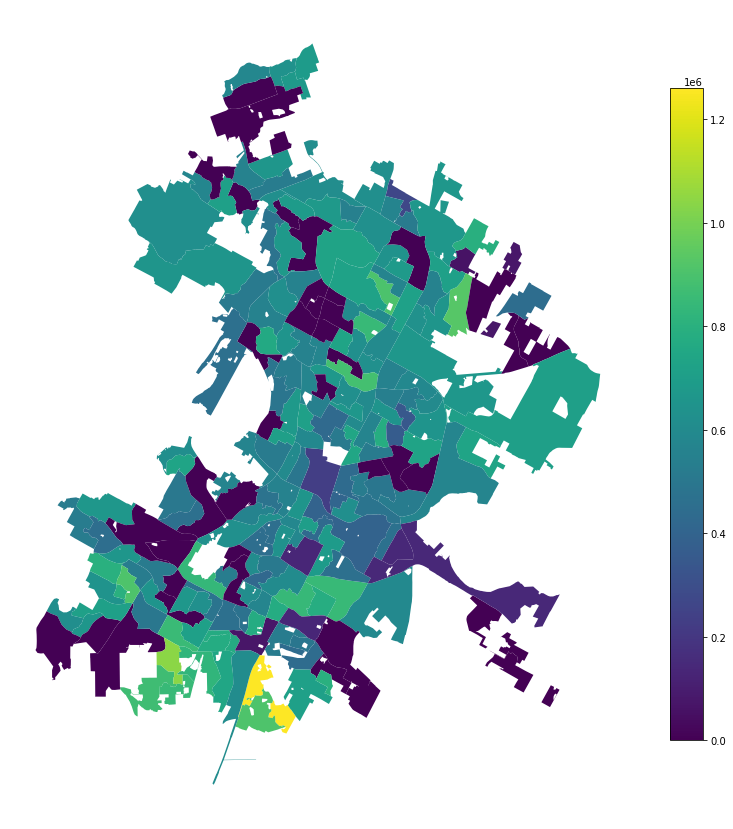

In [41]:
# Recycling in Austin
ax = recycling_boundaries.plot(column='load', legend=True, figsize=(15, 15), legend_kwds={'shrink': 0.8})
ax.set_axis_off()

In [42]:
# Garbage Collection vs. Recycling Single Stream
garbage_boundaries.head()

,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry,load,zipcode,People/Sq. Mile
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ...",1601320.0,78757 78758 78759,4111.466667
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ...",1694420.0,78748,1961.730000
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ...",1941260.0,78744,1464.780000
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ...",1887360.0,78725 78724,336.360000
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ...",2210680.0,78754 78753,2229.345000


In [43]:
recycling_boundaries.head()

,created_by,shape_area,area_supervisor,created_date,objectid_1,old_route,objectid,route_name,service_week,shape_length,modified_by,cart_delivery,service_day,modified_date,primary_key,geometry,load
0,Zimmerman,37060562.8085938,Willie Simmons,2007-10-01T00:00:00+00:00,147,RHBU16,182,RHBU13,B,32863.7931563218,Zimmerman,Oct 10 - Oct 29,Thursday,2020-09-28T00:00:00+00:00,149,"MULTIPOLYGON (((-97.77291 30.36593, -97.77288 ...",553960.0
1,Zimmerman,19838551.0253906,Johnny Williams,2007-10-01T00:00:00+00:00,77,RHBU13,93,RHBU53,B,21073.4691183319,Zimmerman,Oct 10 - Oct 29,Thursday,2020-09-28T00:00:00+00:00,78,"MULTIPOLYGON (((-97.76215 30.35763, -97.76207 ...",650570.0
2,Zimmerman,10138292.75,Willie Simmons,2007-10-01T00:00:00+00:00,42,RTAU12,49,RTAU12,A,14802.0931359868,Zimmerman,Nov 17 - Dec 2,Tuesday,2020-09-28T00:00:00+00:00,43,"MULTIPOLYGON (((-97.78116 30.22779, -97.78141 ...",605820.0
3,Zimmerman,26332018.9570313,Willie Simmons,2007-10-01T00:00:00+00:00,125,RFAU16,148,RFAU11,A,27218.9661254287,Zimmerman,Oct 29 - Nov 15,Friday,2020-10-13T00:00:00+00:00,126,"MULTIPOLYGON (((-97.75838 30.30331, -97.75835 ...",675740.0
4,Zimmerman,25537794.7128906,Chris Farr,2007-10-01T00:00:00+00:00,16,RMAS40,18,RMAS40,A,24756.3262855686,Zavala,Dec 2 - Dec 20,Monday,2020-10-01T00:00:00+00:00,16,"MULTIPOLYGON (((-97.79855 30.19531, -97.79823 ...",458080.0


In [58]:
aux_garbage_boundaries = garbage_boundaries[["garb_rt", "geometry", "load"]].rename(columns={"garb_rt": "route_name"})
aux_recycling_boundaries = recycling_boundaries[["route_name", "geometry", "load"]]

In [59]:
aux_garbage_boundaries.shape, len(aux_garbage_boundaries["route_name"].unique())

((184, 3), 184)

In [60]:
aux_recycling_boundaries.shape, len(aux_recycling_boundaries["route_name"].unique())

((209, 3), 209)

In [61]:
for i, route in enumerate(aux_recycling_boundaries['route_name']):
  loads = []
  for j, load in enumerate(aux_garbage_boundaries["load"]):
    if aux_recycling_boundaries.loc[i, 'geometry'].intersects(aux_garbage_boundaries.loc[j, 'geometry']):
      loads.append(aux_garbage_boundaries.loc[j, 'load'])

  aux_recycling_boundaries.loc[i, "garbage_load"] =  np.mean(loads)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [62]:
aux_recycling_boundaries.rename(columns={"load": "recycling_load"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [75]:
aux_recycling_boundaries = aux_recycling_boundaries[aux_recycling_boundaries["recycling_load"] > 0]

In [78]:
# Waste diversion rate
# WD = R / (R + G)
aux_recycling_boundaries["ratio"] = aux_recycling_boundaries["recycling_load"] / (aux_recycling_boundaries["recycling_load"] + aux_recycling_boundaries["garbage_load"]) * 100

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [79]:
aux_recycling_boundaries["ratio"].describe()

count    173.000000
mean      30.579451
std        7.172007
min        2.808131
25%       27.782208
50%       31.032986
75%       34.920607
max       46.141347
Name: ratio, dtype: float64

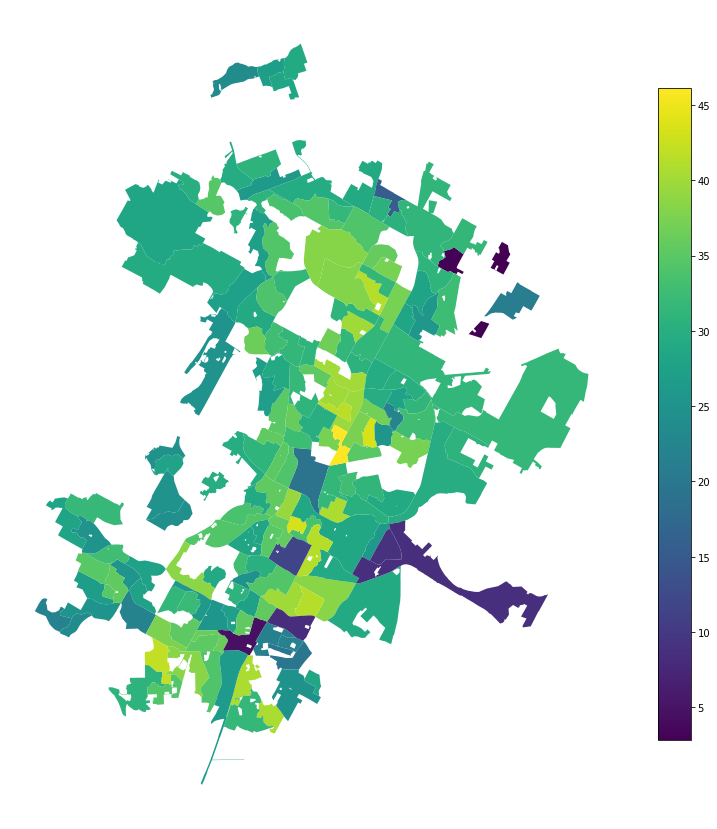

In [80]:
# Waste diversion rate in 2020
ax = aux_recycling_boundaries.plot(column='ratio', legend=True, figsize=(15, 15), legend_kwds={'shrink': 0.8})
ax.set_axis_off()

### Modelling

In [29]:
garbage_data = data[data['Load Type'] == 'GARBAGE COLLECTIONS']
garbage_data = garbage_data[garbage_data['Route Number'].isin(route_numbers)]

In [30]:
garbage_data['date'] = pd.to_datetime(garbage_data['Load Time'].dt.strftime('%Y-%d-%m'), format='%Y-%d-%m')

In [31]:
for year in garbage_data.date.dt.year.unique():
  print(year, len(garbage_data[garbage_data.date.dt.year == year].date.dt.dayofyear.unique()))

2004 74
2005 260
2006 261
2007 260
2008 262
2009 263
2010 261
2011 263
2012 265
2013 263
2014 265
2015 264
2016 264
2017 263
2018 264
2019 264
2020 266
2021 135


In [32]:
garbage_data.sort_values(by='date', inplace=True)
garbage_data.reset_index(drop=True, inplace=True)

In [33]:
# Aggregate data by route and date (sum the load weight of each route and day)
garbage_data = garbage_data.groupby(['Route Number', 'Load Date']).agg({'Load Weight': 'sum'}).reset_index() 
garbage_data.sort_values(by='Load Date', inplace=True)
garbage_data.head()

,Route Number,Load Date,Load Weight
35096,PAM01,2004-02-28,30600.0
79757,PAW60,2004-08-25,38560.0
81477,PAW62,2004-08-25,33600.0
80606,PAW61,2004-08-25,40580.0
5255,PAF60,2004-08-25,26400.0


In [34]:
garbage_data['Population Density'] = garbage_data['Route Number']
garbage_data['Population Density'].replace(density_by_route, inplace=True)

In [35]:
# To predict the load weight collected on a specific route, it might be useful to have the load weight of the previous week(s) i.e. load weight at t-1, t-2, etc.
for route in garbage_data['Route Number'].unique():
  mask = (garbage_data['Route Number'] == route)

  # Add lag features
  garbage_data.loc[mask, 'Load Weight(t-1)'] = garbage_data.loc[mask, 'Load Weight'].shift(1)
  garbage_data.loc[mask, 'Load Weight(t-2)'] = garbage_data.loc[mask, 'Load Weight'].shift(2)
  garbage_data.loc[mask, 'Load Weight(t-3)'] = garbage_data.loc[mask, 'Load Weight'].shift(3)

  # Add average load by route
  #garbage_data['Average Load'] = garbage_data.groupby(['Route Number', 'Load Date'])['Load Weight(t-1)'].transform('mean')

In [36]:
# Add date-related features
garbage_data['Year'] = garbage_data['Load Date'].dt.year 
garbage_data['Month'] = garbage_data['Load Date'].dt.month
garbage_data['Day'] = garbage_data['Load Date'].dt.day

In [37]:
garbage_data.dropna(inplace=True)

In [38]:
garbage_data = garbage_data[garbage_data["Load Date"].dt.year >= 2010]

In [39]:
### Forecast one week (business days only) of garbage collections

In [40]:
garbage_data = garbage_data[garbage_data['Load Date'] < '2021-07-11']  # monday
garbage_data['Load Date'].unique()[-5:]

array(['2021-07-05T00:00:00.000000000', '2021-07-06T00:00:00.000000000',
       '2021-07-07T00:00:00.000000000', '2021-07-08T00:00:00.000000000',
       '2021-07-09T00:00:00.000000000'], dtype='datetime64[ns]')

In [41]:
train_data = garbage_data[garbage_data['Load Date'] < '2021-07-05']
test_data = garbage_data[garbage_data['Load Date'] >= '2021-07-05']

In [42]:
x_train = train_data[['Route Number', 'Load Weight(t-1)', 'Load Weight(t-2)', 'Load Weight(t-3)', 'Year', 'Month', 'Day']]
y_train = train_data['Load Weight']

x_test = test_data[['Route Number', 'Load Weight(t-1)', 'Load Weight(t-2)', 'Load Weight(t-3)', 'Year', 'Month', 'Day']]
y_test = test_data['Load Weight']

In [43]:
encoder = preprocessing.LabelEncoder()
encoder.fit(x_train['Route Number'])

x_train['Route Number'] = encoder.transform(x_train['Route Number'])
x_test['Route Number'] = encoder.transform(x_test['Route Number'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [44]:
x_train_matrix = xgboost.DMatrix(data=x_train, label=y_train)
x_test_matrix = xgboost.DMatrix(data=x_test)

In [45]:
params = {
    'objective': 'reg:squarederror',
    'seed': 123
}

In [46]:
model = xgboost.train(params, x_train_matrix, num_boost_round=50)

In [47]:
feature_importance = model.get_fscore()
feature_importance

{'Day': 247,
 'Load Weight(t-1)': 579,
 'Load Weight(t-2)': 501,
 'Load Weight(t-3)': 468,
 'Month': 198,
 'Route Number': 547,
 'Year': 230}

In [48]:
# Construction and manufacturing industries are among the industries that waste the most.
# Add ammount of each of these industries per route as feature ?

In [49]:
predictions = model.predict(x_test_matrix)

In [50]:
# Compare against baseline : Load Weight(t-1)
# If < 1, model prediction is worse than the baseline
mean_squared_error(y_true=np.array(y_test), y_pred=np.array(x_test['Load Weight(t-1)'])) / mean_squared_error(y_true=np.array(y_test), y_pred=predictions)

1.5189533282524808

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
